In [98]:
!hostname

cn824.wexac.weizmann.ac.il


In [99]:
import os
print(os.getcwd())

/home/projects/hornsteinlab/Collaboration/Guy_Lior


# Imports and Enviroment Setup

In [100]:

import sys
import numpy as np
import cv2 
import pandas as pd
%matplotlib inline
import logging
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap

# ---WORKING ENV SETUP---
NOVA_HOME = "/home/projects/hornsteinlab/giliwo/NOVA"
# home/projects/hornsteinlab/giliwo/NOVA
#'/home/projects/hornsteinlab/Collaboration/NOVA' 
NOVA_DATA_HOME = '/home/projects/hornsteinlab/Collaboration/NOVA'

os.environ['NOVA_HOME'] = NOVA_HOME
sys.path.insert(1, os.getenv("NOVA_HOME"))
print(f"NOVA_HOME: {os.getenv('NOVA_HOME')}")

from src.common.utils import load_config_file, get_class
from src.preprocessing.preprocessors.preprocessor_base import Preprocessor
from src.preprocessing.preprocessing_utils import rescale_intensity, fit_image_shape, get_image_focus_quality,get_nuclei_count, crop_image_to_tiles, extract_polygons_from_mask, get_nuclei_segmentations, is_image_focused, is_contains_whole_nucleus
from tools.preprocessing_tools.image_sampling_utils import sample_images_all_markers_all_lines as sample_images_all_markers_all_lines_processed
%load_ext autoreload
%autoreload 2

NOVA_HOME: /home/projects/hornsteinlab/giliwo/NOVA
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:

#------init processor------
config_path = f"./NOVA/manuscript/preprocessing_config_AAT-NOVA/PreprocessingBaseConfigAATNOVA"


run_config = load_config_file(config_path, '_preprocessing')

logging.info(f"Importing preprocessor class.. {run_config.PREPROCESSOR_CLASS_PATH}")
preprocessor_class: Preprocessor = get_class(run_config.PREPROCESSOR_CLASS_PATH)
    
logging.info(f"Instantiate preprocessor {type(preprocessor_class)}")
preprocessor: Preprocessor = preprocessor_class(run_config)

root_directory_raw = run_config.RAW_FOLDER_ROOT #('raw', 'FUNOVA', 'ordered')

#------INPUT PATHS------
root_directory_raw = run_config.RAW_FOLDER_ROOT #('raw', 'FUNOVA', 'ordered')
root_directory_proc = run_config.PROCESSED_FOLDER_ROOT #('processed', 'FUNOVA', 'processed')


# Utils

In [102]:
# -----------------
# Setup colormaps
# -----------------
colors = [(0, 'black'), (1, 'red')]
cmap_black_to_red = LinearSegmentedColormap.from_list("BlackToRed", colors)
colors = [(0, 'black'), (1, 'royalblue')]
cmap_black_to_blue = LinearSegmentedColormap.from_list("BlackToBlue", colors)
cmap_channels = {'MARKER': cmap_black_to_red, 'DAPI': cmap_black_to_blue}


In [103]:
def pretty(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

In [104]:
def calc_image_stats(img):
    return round(img.min(), 4), round(img.max(), 4), round(img.var(), 4)


In [105]:
# processing main part from - PREPROCESSOR BASE
from typing import Dict
from cellpose import models

NUCLEUS_MARKER_NAME = "DAPI"

def process_site(images_group, preprocessor: Preprocessor):
        site_image_group = {}
        nucleus_path = images_group[NUCLEUS_MARKER_NAME]
        processed_nucleus = preprocessor._get_valid_site_image(nucleus_path)
        if processed_nucleus is None:
            return True, "DAPI: site out-of-focus", nucleus_path
        site_image_group[NUCLEUS_MARKER_NAME] = processed_nucleus, nucleus_path 
       
        markers = preprocessor._Preprocessor__sort_markers(images_group)
        # For being able to filter out DAPI in case all panel markers are invalid, DAPI must be last
        for marker_name in markers: 
            if marker_name == NUCLEUS_MARKER_NAME:
                 continue
            marker_path = images_group[marker_name]
            processed_marker = preprocessor._get_valid_site_image(marker_path)
            if processed_marker is None: 
                return True, f"{marker_name}: site out-of-focus", marker_path
            site_image_group[marker_name] = processed_marker, marker_path

        return site_image_group

def prepare_nucleus_tiles(nucleus_image: np.ndarray, preprocessing_config):
        # mask using cell pose 
        nuclei_mask = get_nuclei_segmentations(
            img=nucleus_image,
            cellpose_model=models.Cellpose(gpu=True, model_type='nuclei'),
            diameter=preprocessing_config.CELLPOSE['NUCLEUS_DIAMETER'],
            cellprob_threshold=preprocessing_config.CELLPOSE['CELLPROB_THRESHOLD'],
            flow_threshold=preprocessing_config.CELLPOSE['FLOW_THRESHOLD'],
            show_plot=False
        )
        # Tile the nucleus mask 
        nuclei_mask_tiled = crop_image_to_tiles(nuclei_mask, preprocessing_config.TILE_INTERMEDIATE_SHAPE)
        return nuclei_mask_tiled

def prepare_tiles(site_image_group, preprocessor: Preprocessor, process_tiles = True):
        processed_images: Dict[str, np.ndarray ] = {}
        tiles_str = "valid " if process_tiles else ""

        processed_nucleus = site_image_group[NUCLEUS_MARKER_NAME][0]
        nucleus_path = site_image_group[NUCLEUS_MARKER_NAME][1]

        # Nucleus Valid Tiles
        if process_tiles:
            valid_tiles_indexes, nuclei_mask_tiled  = preprocessor._get_valid_tiles_indexes(processed_nucleus)
        else:
            nuclei_mask_tiled = prepare_nucleus_tiles(processed_nucleus, preprocessor.preprocessing_config)
            valid_tiles_indexes = [idx for idx, tile in enumerate(nuclei_mask_tiled) if tile is not None]
        
        if not len(valid_tiles_indexes):
            return True, f"{NUCLEUS_MARKER_NAME}: no valid tiles."
        

        markers = preprocessor._Preprocessor__sort_markers(site_image_group)

        for marker_name in markers: 
            if marker_name == NUCLEUS_MARKER_NAME:
                 continue

            processed_marker = site_image_group[marker_name][0]
            marker_path = site_image_group[marker_name][1]

            # Pair marker and nucleus images
            image_pair = np.stack([processed_marker, processed_nucleus], axis=-1)

            # Crop to tiles and take the valid ones
            image_pair_tiled = crop_image_to_tiles(image_pair, preprocessor.preprocessing_config.TILE_INTERMEDIATE_SHAPE)

            if process_tiles:
                # Process and filter tiles based on variance and intensity
                image_pair_tiled, valid_tiles_indexes = preprocessor._Preprocessor__process_and_filter_tiles(image_pair_tiled, valid_tiles_indexes, marker_name)
            
            # If no valid tiles were found, don't save this marker
            if len(valid_tiles_indexes) == 0: 
                print(f"[{marker_name}] No valid tiles were found for marker image: {marker_path}")
                continue
            processed_images[marker_name] = image_pair_tiled
        
        return processed_images



def process_image(images_group, preprocessor: Preprocessor):
        processed_images: Dict[str, np.ndarray ] = {}

        nucleus_path = images_group[NUCLEUS_MARKER_NAME]
        processed_nucleus = preprocessor._get_valid_site_image(nucleus_path)
        if processed_nucleus is None:
            return True, "DAPI: site out-of-focus", nucleus_path
        
        # Get valid tile indexes for the nucleus image
        valid_tiles_indexes, nuclei_mask_tiled  = preprocessor._get_valid_tiles_indexes(processed_nucleus) 
                        
        markers = preprocessor._Preprocessor__sort_markers(images_group)


        # For being able to filter out DAPI in case all panel markers are invalid, DAPI must be last
        for marker_name in markers: 
            if marker_name == NUCLEUS_MARKER_NAME:
                 continue
            marker_path = images_group[marker_name]
            
            processed_marker = preprocessor._get_valid_site_image(marker_path)
            if processed_marker is None: 
                return True, f"{marker_name}: site out-of-focus", marker_path
            
            # Pair marker and nucleus images
            image_pair = np.stack([processed_marker, processed_nucleus], axis=-1)

            # Crop to tiles and take the valid ones
            image_pair_tiled = crop_image_to_tiles(image_pair, preprocessor.preprocessing_config.TILE_INTERMEDIATE_SHAPE)

            # Process and filter tiles based on variance and intensity
            image_pair_processed_valid_tiles, valid_tiles_indexes = preprocessor._Preprocessor__process_and_filter_tiles(image_pair_tiled, valid_tiles_indexes, marker_name)
        
            # If no valid tiles were found, don't save this marker
            if len(valid_tiles_indexes) == 0: 
                print(f"[{marker_name}] No valid tiles were found for marker image: {marker_path}")
                continue
            print(image_pair_processed_valid_tiles.shape)
            processed_images[marker_path] = image_pair_processed_valid_tiles

            
        __shapes =  {m: v.shape for m, v in processed_images.items()}
        logging.info(f"Shape of processed images: {__shapes}")
            
        return processed_images

In [106]:
def mark_tiles_to_remove(fig, axs, max_intensity_below_threshold, box_color='yellow', tile_is_marker=False):
    frame_num = 1 if tile_is_marker else 0
    rect = patches.Rectangle((0, 0), 100, 100, linewidth=5, edgecolor=box_color, facecolor='none')
    axs[frame_num].add_patch(rect)

    frame = patches.Rectangle((-0.1, 0), 1.2, 1.1, transform=fig.transFigure,
                              linewidth=5, edgecolor=box_color, facecolor='none')
    fig.patches.append(frame)

In [107]:
import random
import re

def find_marker_folders(batch_path, depth=5, exclude_DAPI=True):
    """Returns paths of all marker folder in a batch (assumed to be depth of 5 levels)
    works with recursion
    Args:
        batch_path (string):  full path of batch folder
        depth (int, optional): depth of marker sub-folders. Defaults to 5.
        exclude_DAPI (boolean, defualt True): whether to exclude the DAPI folders
        Note: Markers are assumend to be always in a given constant "depth"

    Yields:
        string: a path of marker folder
    """
    
    # Recursively list files and directories up to a certain depth
    depth -= 1
    with os.scandir(batch_path) as input_data_folder:
        
        for entry in sorted(input_data_folder, key=lambda e: e.name):
        
            # if that's not a marker directory, recursion...
            if entry.is_dir() and depth > 0:
                yield from find_marker_folders(entry.path, depth, exclude_DAPI)
            elif not entry.is_dir() and depth > 0:
                continue
            # if that's a marker directory
            elif depth==0: 
                marker_name = os.path.basename(entry.path)
                if (exclude_DAPI) and marker_name=='DAPI':
                    continue
                else:
                    # This is a list of arguments, used as the input of analyze_marker()
                    yield entry.path

def sample_image_names_per_marker(input_data_dir, sample_size=1, raw=False):
    """
    For a given target marker, this function samples file names of images 
    (each image is stored in npy of (n_tiles, 100, 100, 2), AKA target and DAPI marker 
    
    Args:
        input_data_dir (string): full path of marker directory
        Note: "input_data_dir" has to point to a marker directory
        sample_size (int, optional): how  many images to sample. Defaults to 1.
        raw (bool): if to sample raw files or not
    Returns:
        _type_: _description_
    """
    try:
        # This will hold the full path of n images (n is defined by "sample_size") of the marker
        filenames = random.sample(sorted(os.listdir(input_data_dir)), sample_size)
        logging.info(f"\nsample_image_names_per_marker: {input_data_dir}. {sample_size} images per marker.")
    except ValueError:
        npy_size = len(sorted(os.listdir(input_data_dir)))
        filenames = random.sample(sorted(os.listdir(input_data_dir)), npy_size) 
        logging.info(f"\n!!! This marker has less then {sample_size} images. Loaded {input_data_dir}. {npy_size} images per marker.")
        
        
    files_list = []
    # Target marker
    for target_file in filenames:
        filename, ext = os.path.splitext(target_file)
        if not raw:
            if ext == '.npy':
                image_filename = os.path.join(input_data_dir, target_file)
        
                # Add to list
                files_list.append(image_filename)
        
            else:
                logging.info(f"sampled file {target_file} was not a npy. re-sampling.. ")
                continue
        elif raw:
            if ext == '.tif' or ext == '.tiff':
                image_filename = os.path.join(input_data_dir, target_file)
                marker = os.path.basename(input_data_dir)
                if marker == 'DAPI':
                    files_list.append(image_filename)
                else:
                    files_list.append(image_filename)
                    # Replace marker name with "DAPI"
                    image_filename = image_filename.replace(marker, "DAPI")

                    # Replace ch2, ch3, ch4 with ch1
                    image_filename = re.sub(r"ch[2-4]", "ch1", image_filename)
                    files_list.append(image_filename)

            else:
                logging.info(f"sampled file {target_file} was not a tif. re-sampling.. ")
                continue

    return files_list

def sample_images_all_markers(cell_line_path=None, sample_size_per_markers=1, num_markers=26, depth=2, raw=False, rep_count=2,
                              cond_count=2, exclude_DAPI=False, markers_to_include=None):
        """Samples random raw images for a given batch 

        Args:
            cell_line_path (string): path to cell line images
            sample_size_per_markers (int, optional): how many images to sample for each marker. Defaults to 1.
            num_markers (int, optional): how many markers to sample. Defaults to 10.
            raw (bool): if to sample raw files or not

        Returns:
            list: list of paths (strings) 
        """
        sampled_images = []
        sampled_markers = set()
        
        # Get a list of all marker folders
        if raw:
            num_markers*=rep_count*cond_count
        
        marker_subfolder = find_marker_folders(cell_line_path, depth=depth, exclude_DAPI=exclude_DAPI)
        # Sample n markers, and for each marker, sample k images (where n=num_markers and k=sample_size_per_markers)
        for marker_folder in marker_subfolder:
            if not os.path.isdir(marker_folder):
                continue
            if markers_to_include:
                if os.path.basename(marker_folder) not in markers_to_include:
                    continue
            n_images = 0
            if (len(sampled_markers) < num_markers):
                
                if (n_images<sample_size_per_markers):
                    if 'DAPI' in marker_folder and not raw:
                        sample_size_per_markers *= num_markers
                    sampled_marker_images = sample_image_names_per_marker(marker_folder,
                                                                          sample_size=sample_size_per_markers, 
                                                                          raw=raw)
                    
                    if sampled_marker_images:
                        sampled_images.extend(sampled_marker_images)
                        sampled_markers.add(marker_folder)
                        
                        n_images += 1
                if (n_images==sample_size_per_markers): 
                    continue
            
        logging.info(f"sampled_images: {len(sampled_images)}, sampled_markers: {len(sampled_markers)}")
        return sampled_images

def sample_images_all_markers_all_lines(input_dir_batch=None, _sample_size_per_markers=150, _num_markers=26, 
                                        raw=False, all_conds=False, all_panels=False, rep_count=2, cond_count=2, exclude_DAPI=False, markers_to_include=None):
    
    images_paths = []
    
    if input_dir_batch is None:
        raise Exception(f"input argument input_dir_batch is None. ")
    logging.info(f"\n\n[sample_images_all_markers_all_lines]: input_dir_batch:{input_dir_batch}, _sample_size_per_markers:{_sample_size_per_markers}, _num_markers:{_num_markers}")
    
    for cell_line in sorted(os.listdir(input_dir_batch)):
        
        # get the full path of cell line images
        cell_line_path = os.path.join(input_dir_batch, cell_line)

        logging.info(f"\n\ncell_line: {cell_line} {cell_line_path}")
        # Sample markers and then sample images of these markers. The returened value is a list of paths (strings)
        # 
        dir_paths = [cell_line_path]
        depth = 4
        if raw and all_panels:
            dir_paths = [os.path.join(cell_line_path, panel) for panel in os.listdir(cell_line_path)]
            depth = 3
        if all_conds:
            dir_paths = [os.path.join(path, cond) for path in dir_paths for cond in os.listdir(path) ]
            depth = 2
        for path in dir_paths:
            paths = sample_images_all_markers(path, sample_size_per_markers=_sample_size_per_markers, 
                                          num_markers=_num_markers, depth = depth , raw=raw, rep_count=rep_count, cond_count=cond_count, exclude_DAPI=exclude_DAPI, markers_to_include=markers_to_include)
            images_paths.extend(paths)

   
    return images_paths

In [108]:
def plot_site(image_path,ch_idx):
        print("PATH:", image_path)
        image = cv2.imread(image_path, cv2.IMREAD_ANYDEPTH)
        
        # Check if file is corrupted
        if image is None or np.size(image) == 0:
            logging.warning(f"File {image_path} is corrupted. Skiping this one.")
            return None
            
        image = fit_image_shape(image, run_config.EXPECTED_IMAGE_SHAPE) 
        image = rescale_intensity(image,\
                                    lower_bound=run_config.RESCALE_INTENSITY['LOWER_BOUND'][ch_idx],\
                                    upper_bound=run_config.RESCALE_INTENSITY['UPPER_BOUND'][ch_idx]) 
        # Plot the site image
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.show()

def plot_img(image):
        # Plot the site image
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.show()


def processed_file(input_tiles, meta_data, tile_index = 0, path = None, marker_name = "Marker",
                           SHOW_DAPI_FAIL = True, SHOW_MARKER_FAIL = True, SHOW_ALL_TILES = False, dapi_specific_reason = "", marker_specific_reason = ""):
        def plot_tile(meta_data):
            batch, cell_line, cond , path = meta_data
            filename = os.path.basename(path)

            # Plot the images
            print(f"Plotting {batch} {cell_line} {cond} {filename} tile:{tile_index} - DAPI: {dapi_reason}, Marker: {marker_reason}\n PATH = {path}")

            # Create figure and axes
            fig, axs = plt.subplots(2, 2)
            axs = axs.flatten()
            plt.subplots_adjust(hspace=0.4)

            imgs_to_show = [dapi_img, marker_img, scaled_dapi_img, scaled_marker_img]
            cmaps = [cmap_channels['DAPI'], cmap_channels['MARKER'],
                    cmap_channels['DAPI'], cmap_channels['MARKER']]

            for i, layer in enumerate(imgs_to_show):
                ax = axs[i]
                ax.imshow(layer, cmap=cmaps[i], vmin=0, vmax=1)
                pretty(ax)

            # Titles
            axs[0].set_title(f"DAPI\nmin-max {min_dapi}-{max_dapi}\nvar: {var_dapi}")
            axs[1].set_title(f"{marker_name}\nmin-max {min_marker}-{max_marker}\nvar: {var_marker}")

            # Labels under scaled
            axs[2].set_title(f"min-max {min_scaled_dapi}-{max_scaled_dapi}\nvar: {var_scaled_dapi}\nReason: {dapi_reason}", size=10)
            axs[3].set_title(f"min-max {min_scaled_marker}-{max_scaled_marker}\nvar: {var_scaled_marker}\nReason: {marker_reason}", size=10)

            # Rectangles
            if REMOVE_DAPI:
                color = 'purple' if (dapi_reason and 'dead cells' in dapi_reason.lower()) else 'yellow'
                mark_tiles_to_remove(fig, axs, True, box_color=color, tile_is_marker=False)
            if REMOVE_MARKER:
                mark_tiles_to_remove(fig, axs, True, box_color='yellow', tile_is_marker=True)

            plt.show()
            
        ###########################################################################################

        tile = input_tiles[tile_index]

        # Extract channels
        marker_img = tile[:, :, 0]
        dapi_img = tile[:, :, 1]

        # Scale using preprocessor's method
        tile_stacked = np.stack([marker_img, dapi_img], axis=-1)
        scaled_tile = preprocessor._Preprocessor__apply_rescale_intensity_to_multi_channel_tile(tile_stacked)

        scaled_marker_img = scaled_tile[:, :, 0]
        scaled_dapi_img = scaled_tile[:, :, 1]

        # Stats originals
        min_dapi, max_dapi, var_dapi = calc_image_stats(dapi_img)
        min_marker, max_marker, var_marker = calc_image_stats(marker_img)

        # Stats scaled
        min_scaled_dapi, max_scaled_dapi, var_scaled_dapi = calc_image_stats(scaled_dapi_img)
        min_scaled_marker, max_scaled_marker, var_scaled_marker = calc_image_stats(scaled_marker_img)

        # Pass/fail checks with reasons 
        dapi_fail, dapi_reason = preprocessor._Preprocessor__is_empty_tile_dapi(dapi_img, scaled_dapi_img, 'DAPI')
        marker_fail, marker_reason = preprocessor._Preprocessor__is_empty_tile_target(marker_img, scaled_marker_img, marker_name)


        REMOVE_DAPI = dapi_fail
        REMOVE_MARKER = marker_fail

        if dapi_specific_reason and REMOVE_DAPI:
            dapi_reason_show =  (dapi_specific_reason in dapi_reason)
        else:
            dapi_reason_show = True

        show_failed_dapi =      REMOVE_DAPI and SHOW_DAPI_FAIL and dapi_reason_show

        if marker_specific_reason and REMOVE_MARKER:
            marker_reason_show =  (marker_specific_reason in marker_reason)
        else:
            marker_reason_show = True
            
        show_failed_marker =    REMOVE_MARKER and SHOW_MARKER_FAIL and marker_reason_show
        show_passed_dapi =      (not REMOVE_DAPI) and (not SHOW_DAPI_FAIL)
        show_passed_marker =    (not REMOVE_MARKER) and (not SHOW_MARKER_FAIL)

        if show_failed_dapi or show_failed_marker or (show_passed_dapi and show_passed_marker) or SHOW_ALL_TILES:
            plot_tile(meta_data)
        else:
            print("Skipping...", "( REMOVE_DAPI:", REMOVE_DAPI, "REMOVE_MARKER:", REMOVE_MARKER, ")")

In [109]:
def process_processed_files(paths, markers, num_sites_to_process, num_tiles_to_show, show_dapi_fail, show_marker_fail, show_all_tiles, dapi_specific_reason = "", marker_specific_reason = ""):
    """
        (1) parse paths to df
        (2) for each marker:
            (2.a)   extract marker paths choose NUM_SITES_TO_PROCESS indices from len(marker paths) to continue processing 
            (2.b)   process tiles (crop to tiles, rescale intensity, filter by preprocessing thresholds)
                    and plot NUM_TILES_TO_SHOW tiles if SHOW_TILES = True
                    (!) further plotting options can be adjusted using the flags - 
                        SHOW_DAPI_FAIL, SHOW_MARKER_FAIL, SHOW_ALL_TILES
        """
    ####### STEP (1) ####### 
    paths_df = pd.DataFrame(paths, columns=['path'])
    split_cols = paths_df['path'].str.split(os.sep).apply(lambda x: x[-5:])  # last 6 components
    paths_df[['batch', 'cell_line', 'cond', 'marker_name', 'filename']] = pd.DataFrame(split_cols.tolist(), index=paths_df.index)
    paths_df["site"] = paths_df["filename"].str.split('-').str[0]

    for marker in markers:
        print("X"*40)
        print("analyzing marker: ", marker)
        print("X"*40)

        ####### STEP (2.a.) ####### 
        # extract marker paths data
        marker_df = paths_df[paths_df["marker_name"] == marker]

        # get indeices to process and plot
        num_paths = len(marker_df)
        sites_idx_to_show = np.random.choice(range(num_paths), 
                                             min(num_paths, num_sites_to_process), 
                                             replace=False)
        
        ####### STEP (2.b.) ####### 
        for i in sites_idx_to_show:
                print("-"*40)
                print("analyzing path ", i+1, "/", num_paths)

                # extract path metadata
                path_row = marker_df.iloc[i]
                path = path_row["path"]
                meta_data = path_row["batch"], path_row["cell_line"], path_row["cond"], path_row["path"]

                if path is not None:
                    # load processed image
                    all_tiles = np.load(path, allow_pickle=True)
                    if all_tiles.shape[0] == 0:
                        print(f"File {path} is empty. Skiping this one.")
                        continue
                    
                    # get indices to process and plot
                    num_tiles = all_tiles.shape[0]
                    tiles_idx_to_show = np.random.choice(range(num_tiles), 
                                             min(num_tiles, num_tiles_to_show), 
                                             replace=False)

                    for tile_idx in tiles_idx_to_show:
                        print("*"*40)
                        print(f"Tile {tile_idx+1}/{num_tiles}")

                        # process and plot tile
                        processed_file(all_tiles, meta_data, tile_index = tile_idx, path = path, 
                                            marker_name = marker,
                                            SHOW_DAPI_FAIL=show_dapi_fail, SHOW_MARKER_FAIL=show_marker_fail, SHOW_ALL_TILES=show_all_tiles,
                                            dapi_specific_reason=dapi_specific_reason,
                                            marker_specific_reason=marker_specific_reason)

def process_raw_files(paths, markers_list, num_sites_to_process, show_bad_sites, show_passed_sites, show_tiles, num_tiles_to_show, show_dapi_fail, show_marker_fail, show_all_tiles, dapi_specific_reason = "", marker_specific_reason = ""):
    """
        (1) match DAPI and marker paths to have matching site (.tiff) channels
        (2) for each marker:
            (2.a)   process NUM_SITES_TO_PROCESS sites (rescale intensity, filter by brenner threshold) 
                    and plot failed sites if SHOW_BAD_SITES = True
            (2.b)   process tiles (crop to tiles, rescale intensity, filter by preprocessing thresholds)
                    and plot NUM_TILES_TO_SHOW tiles if SHOW_TILES = True
                    (!) further plotting options can be adjusted using the flags - 
                        SHOW_DAPI_FAIL, SHOW_MARKER_FAIL, SHOW_ALL_TILES
    """
    ####### STEP (1) ####### 
    # Assuming `paths` is a list of full file paths
    paths_df = pd.DataFrame(paths, columns=['path'])

    # Split the path into components
    split_cols = paths_df['path'].str.split(os.sep).apply(lambda x: x[-7:])  # last 8 components
    paths_df[['batch', 'cell_line', 'panel', 'cond', 'rep', 'marker_name', 'filename']] = pd.DataFrame(split_cols.tolist(), index=paths_df.index)
    paths_df["site"] = paths_df["filename"].str.split('-').str[0]

    # Count how many paths each site has
    site_counts = paths_df.groupby('site')['path'].count()

    # Keep only sites that have 2 components (DAPI and marker channels)
    valid_sites = site_counts[site_counts >= 2].index

    # Filter the DataFrame
    filtered_df = paths_df[paths_df['site'].isin(valid_sites)]
    print(f"Valid sites (from all markers): {len(valid_sites)} out of {len(site_counts)} total sites.")

    # split into markers and nuclei
    nuclei = filtered_df[filtered_df["marker_name"] == "DAPI"].rename(columns={"path": "nucleus_path"}).drop(columns=["marker_name"])
    markers = filtered_df[filtered_df["marker_name"] != "DAPI"].rename(columns={"path": "marker_path"})

    # merge markers with nuclei by site (and meta data)
    merged = markers.merge(nuclei, on=['site', 'batch', 'cell_line', 'panel', 'cond', 'rep'], how="inner")
    
    # keys: marker name
    # values: df of marker paths
    marker_dict = {
        marker: group.sort_values("site")
        for marker, group in merged.groupby("marker_name")
    }

    ####### STEP (2) ####### 
    # for each marker 
    for marker in markers_list:
        print("X"*40)
        print("analyzing marker: ", marker)
        print("X"*40)
        
        # extract data
        marker_data = marker_dict[marker]

        # choose indexes to plot randomly
        marker_valid_sites = marker_data.shape[0]
        sites_idx_to_show = np.random.choice(range(marker_valid_sites), 
                                             min(marker_valid_sites, num_sites_to_process), 
                                             replace=False)
        for i in sites_idx_to_show:
            print("-"*40)
            print("analyzing site ", i+1, "/", marker_valid_sites)

            # extract meta data of the path
            path_row = marker_data.iloc[i]
            meta_data = path_row["batch"], path_row["cell_line"], path_row["cond"], path_row["marker_path"]

            ####### STEP (2.a) #######
            # extract paths of the site images
            images_group = {}
            images_group[marker] = path_row['marker_path']
            images_group[NUCLEUS_MARKER_NAME] = path_row['nucleus_path']

            # process site
            site_images_group = process_site(images_group, preprocessor)

            # if site failed 
            if isinstance(site_images_group, tuple):
                print(f"Failed: {site_images_group[1]}")
                if show_bad_sites:
                    reason = site_images_group[1]
                    if "out-of-focus" in reason.lower():
                        channel = reason.split(":")[0]
                        channel_idx = 1 if channel == NUCLEUS_MARKER_NAME else 0
                        plot_site(site_images_group[2], channel_idx)
                continue
            # plot passed sites
            if show_passed_sites:
                print("*"*40)
                print(f"plotting {marker} site")
                plot_site(site_images_group[marker][1], 0)
                print("*"*40)
                print(f"plotting {NUCLEUS_MARKER_NAME} site")
                plot_site(site_images_group[NUCLEUS_MARKER_NAME][1], 0)
            
            ####### STEP (2.a) #######
            # prepare tiles without thresholds (only intensity scaling and cropping)
            # processed_tiles: dict - keys = site path, values = 'prepared' tiles
            processed_tiles = prepare_tiles(site_images_group, preprocessor, process_tiles = False)

            if processed_tiles:
                # extract 'prepared' tiles
                processed_image = processed_tiles[marker]
                num_valid_tiles = processed_image.shape[0]

                if show_tiles:
                    print("plotting ", num_tiles_to_show, "tiles....")

                    # choose indexes to plot randomly
                    tiles_idx_to_show = np.random.choice(range(num_valid_tiles), 
                                                        min(num_valid_tiles, num_tiles_to_show), 
                                                        replace=False)

                    # plot tiles
                    for j in tiles_idx_to_show:
                        print("*"*40)
                        print(f"Tile {j+1}/{num_valid_tiles}")
                        processed_file(processed_image, meta_data, tile_index = j, SHOW_DAPI_FAIL=show_dapi_fail, SHOW_MARKER_FAIL=show_marker_fail, SHOW_ALL_TILES=show_all_tiles,
                                            dapi_specific_reason=dapi_specific_reason,
                                            marker_specific_reason=marker_specific_reason)

# We Start Here...

In [110]:
# choose markers to include
MARKERS = ["TDP-43"] # DAPI IS ADDED AUTOMATICLY
# ["DAPI", "Cas3", "FK-2", "SMI32", "pDRP1", "TOMM20", "pCaMKIIa", "pTDP-43", "TDP-43", "ATF6", "pAMPK", "HDGFL2", "pS6", "PAR", "UNC13A", "Calreticulin", "LC3-II", "p62", "CathepsinD"]

RAW = True # RAW data or processed data
MAIN_DATA_PATH = root_directory_raw if RAW else root_directory_proc
print(MAIN_DATA_PATH)
# choose batches
BATCH = "batch1"

/home/projects/hornsteinlab/Collaboration/Guy_Lior/fuNOVA_Pilot/zstack_collapse_2nd_imaging_sorted


In [111]:
# Sample paths
# TODO: check _num_markers
if RAW:
    paths = sample_images_all_markers_all_lines(
        input_dir_batch=os.path.join(MAIN_DATA_PATH, BATCH),
        _sample_size_per_markers=1,
        _num_markers=2,
        raw=RAW,
        all_conds=True,
        all_panels=True,
        rep_count=2,
        cond_count=2,
        exclude_DAPI=False,
        markers_to_include=MARKERS  
    )
else:
    paths = sample_images_all_markers_all_lines_processed(
    input_dir_batch=os.path.join(MAIN_DATA_PATH, BATCH),
    _sample_size_per_markers=3,
    _num_markers=5,
    raw=False,
    all_conds=True,
    rep_count=10,
    cond_count=2,
    exclude_DAPI=False,
    markers_to_include=MARKERS  
    )
print(f"Sampled {len(paths)} images from {BATCH}.")


Sampled 128 images from batch1.


Valid sites (from all markers): 64 out of 64 total sites.
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
analyzing marker:  TDP-43
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
----------------------------------------
analyzing site  60 / 64
img_focus_quality: 2290.417958354553
Failed: DAPI: site out-of-focus
PATH: /home/projects/hornsteinlab/Collaboration/Guy_Lior/fuNOVA_Pilot/zstack_collapse_2nd_imaging_sorted/batch1/CTL/panelC/Untreated/rep2/DAPI/r15c18f108-ch1t1.tiff


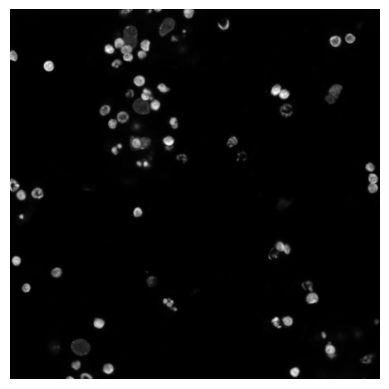

----------------------------------------
analyzing site  5 / 64
----------------------------------------
analyzing site  43 / 64
img_focus_quality: 7010.960813512422
Failed: DAPI: site out-of-focus
PATH: /home/projects/hornsteinlab/Collaboration/Guy_Lior/fuNOVA_Pilot/zstack_collapse_2nd_imaging_sorted/batch1/CTL/panelC/NT-6301-3085/rep1/DAPI/r11c17f102-ch1t1.tiff


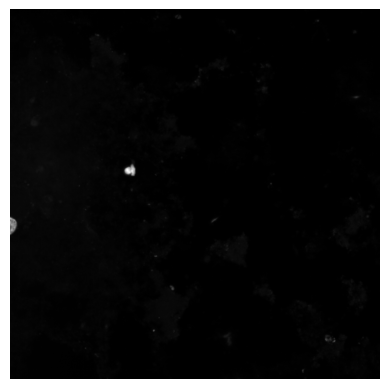

----------------------------------------
analyzing site  26 / 64
----------------------------------------
analyzing site  15 / 64
----------------------------------------
analyzing site  40 / 64
img_focus_quality: 9306.550815477072
Failed: TDP-43: site out-of-focus
PATH: /home/projects/hornsteinlab/Collaboration/Guy_Lior/fuNOVA_Pilot/zstack_collapse_2nd_imaging_sorted/batch1/C9/panelC/NT-1873/rep2/TDP-43/r10c18f135-ch3t1.tiff


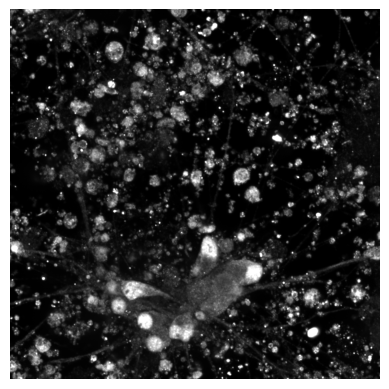

----------------------------------------
analyzing site  64 / 64
img_focus_quality: 2489.3708398273025
Failed: DAPI: site out-of-focus
PATH: /home/projects/hornsteinlab/Collaboration/Guy_Lior/fuNOVA_Pilot/zstack_collapse_2nd_imaging_sorted/batch1/C9/panelC/Untreated/rep2/DAPI/r16c18f95-ch1t1.tiff


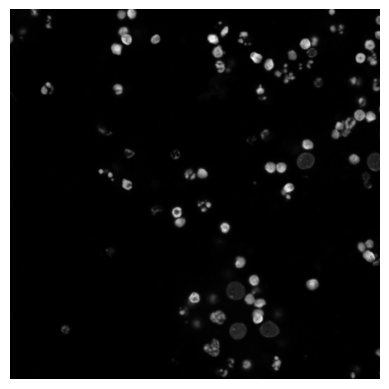

----------------------------------------
analyzing site  8 / 64
----------------------------------------
analyzing site  29 / 64
img_focus_quality: 2452.6828136621225
Failed: DAPI: site out-of-focus
PATH: /home/projects/hornsteinlab/Collaboration/Guy_Lior/fuNOVA_Pilot/zstack_collapse_2nd_imaging_sorted/batch1/C9/panelC/NDUFAB1/rep1/DAPI/r08c05f15-ch1t1.tiff


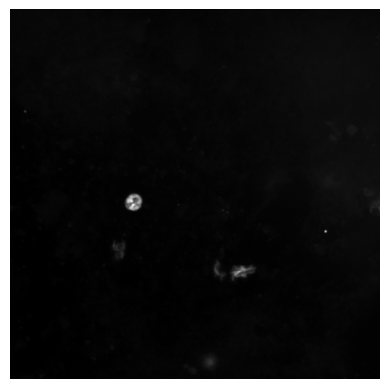

----------------------------------------
analyzing site  19 / 64


In [115]:
# disable logging
import logging
logging.disable(logging.CRITICAL)

# Choose flags
SHOW_BAD_SITES = True # plot sites that did not pass the thresholds
SHOW_PASSED_SITES = False # plot sites that passed the thresholds
NUM_SITES_TO_PROCESS = 10 # number of sites to show (randomaly picked from valid sites)

SHOW_TILES = False # plot tiles
SHOW_DAPI_FAIL = True # plot tiles that did not passed the DAPI thresholds 
SHOW_MARKER_FAIL = False # plot tiles that did not passed the marker thresholds
# (!)   if both SHOW_DAPI_FAIL and SHOW_MARKER_FAIL are false will show only tiles that passed both marker and dapi
SHOW_ALL_TILES = False # plot all tiles regardless of thresholds (passed and not passed) or above flags
NUM_TILES_TO_SHOW = 20 # number of tiles to show (randomaly picked from tiles)

# present tiles only with a specific reason. 
# (!) the string should be exactly as the "Reason [DAPI/Target]" string
# examples: "dead cells" / "Invalid variance" / "Invalid max intensity"
DAPI_SPECIFIC_REASON = "dead cells" 
MARKER_SPECIFIC_REASON = "" 


if RAW: # raw images
        """
        (1) match DAPI and marker paths to have matching site (.tiff) channels
        (2) for each marker, for each one of the matched sites:
            (2.a)   process NUM_SITES_TO_PROCESS sites (rescale intensity, filter by brenner threshold) 
                    and plot failed sites if SHOW_BAD_SITES = True
            (2.b)   process tiles (crop to tiles, rescale intensity, filter by preprocessing thresholds)
                    and plot NUM_TILES_TO_SHOW tiles if SHOW_TILES = True
                    (!) further plotting options can be adjusted using the flags - 
                        SHOW_DAPI_FAIL, SHOW_MARKER_FAIL, SHOW_ALL_TILES
        """
        process_raw_files(paths, MARKERS, 
                        NUM_SITES_TO_PROCESS, SHOW_BAD_SITES, SHOW_PASSED_SITES,
                        SHOW_TILES, NUM_TILES_TO_SHOW, SHOW_DAPI_FAIL, SHOW_MARKER_FAIL, SHOW_ALL_TILES, DAPI_SPECIFIC_REASON, MARKER_SPECIFIC_REASON)
else: # processed images 
        process_processed_files(paths, MARKERS, 
                                NUM_SITES_TO_PROCESS, 
                                NUM_TILES_TO_SHOW, SHOW_DAPI_FAIL, SHOW_MARKER_FAIL, SHOW_ALL_TILES, DAPI_SPECIFIC_REASON, MARKER_SPECIFIC_REASON)